In [4]:
import io
import nltk
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
plt.style.use("ggplot")
from owlready2 import *
import re

In [5]:

def parse_text_to_words(filename):
    """
    Функция принимает на вход обычный текст. На выходе получаем
    двумерный массив из предложений и слов, эти предложения составляющих. 
    """
    with io.open(filename, 'rt', encoding='utf8') as f:
        text = f.read()
    
    sentences = nltk.sent_tokenize(text, language="russian")
    
    new_sentences = []
    for sent in sentences:
        sent = nltk.word_tokenize(sent, language="russian")
        new_sentences.append(sent)
    
    return new_sentences
    
sentences=parse_text_to_words("текст_статьи_ооп.txt")
print("Количество предложений:" + str(len(sentences)))
for sent in sentences[:5]:
    print(sent)

Количество предложений:255
['Объектно-ориентированное', 'программирование', '(', 'ООП', ')', '—', 'методология', 'программирования', ',', 'основанная', 'на', 'представлении', 'программы', 'в', 'виде', 'совокупности', 'объектов', ',', 'каждый', 'из', 'которых', 'является', 'экземпляром', 'определённого', 'класса', ',', 'а', 'классы', 'образуют', 'иерархию', 'наследования', '.']
['Идеологически', 'ООП', '—', 'подход', 'к', 'программированию', 'как', 'к', 'моделированию', 'информационных', 'объектов', ',', 'решающий', 'на', 'новом', 'уровне', 'основную', 'задачу', 'структурного', 'программирования', ':', 'структурирование', 'информации', 'с', 'точки', 'зрения', 'управляемости', ',', 'что', 'существенно', 'улучшает', 'управляемость', 'самим', 'процессом', 'моделирования', ',', 'что', ',', 'в', 'свою', 'очередь', ',', 'особенно', 'важно', 'при', 'реализации', 'крупных', 'проектов', '.']
['Управляемость', 'для', 'иерархических', 'систем', 'предполагает', 'минимизацию', 'избыточности', 'данны

In [6]:
def normalization(sentences):
    """
    На вход принимаем выход из предыдущей функции. На выходе получаем
    двумерный массив из предложений и слов, из которого были удалены 
    знаки пунктуации и стоп-слова. Все слова приводятся к нижнему регистру.
    """
    new_sentences=[]
    for sent in sentences:
        new_list = [word.lower() for word in sent if word.isalnum() and word not in stopwords.words('russian')]
        new_sentences.append(new_list)
    
    return new_sentences

sentences_array = normalization(sentences)
print("Количество предложений:" + str(len(sentences_array)))
for sent in sentences_array[:5]:
    print(sent)

Количество предложений:255
['программирование', 'ооп', 'методология', 'программирования', 'основанная', 'представлении', 'программы', 'виде', 'совокупности', 'объектов', 'каждый', 'которых', 'является', 'экземпляром', 'определённого', 'класса', 'классы', 'образуют', 'иерархию', 'наследования']
['идеологически', 'ооп', 'подход', 'программированию', 'моделированию', 'информационных', 'объектов', 'решающий', 'новом', 'уровне', 'основную', 'задачу', 'структурного', 'программирования', 'структурирование', 'информации', 'точки', 'зрения', 'управляемости', 'существенно', 'улучшает', 'управляемость', 'самим', 'процессом', 'моделирования', 'очередь', 'особенно', 'важно', 'реализации', 'крупных', 'проектов']
['управляемость', 'иерархических', 'систем', 'предполагает', 'минимизацию', 'избыточности', 'данных', 'аналогичную', 'нормализации', 'целостность', 'поэтому', 'созданное', 'удобно', 'управляемым', 'удобно', 'пониматься']
['таким', 'образом', 'тактическую', 'задачу', 'управляемости', 'решаетс

In [7]:


def add_bigrams(sentences_array):
    """
    Добавляет биграммы в массив предложений.
    """
    phrases = Phrases(sentences_array, min_count=3, threshold=10)
    bigram = Phraser(phrases)
    return bigram[sentences_array]

sentences = add_bigrams(sentences_array)
for sent in sentences[:100]:
    for word in sent:
        for symbol in word:
            if symbol == "_":
                print(word)

таким_образом
тип_данных
тип_данных
таким_образом
компонентное_программирование
взаимодействие_объектов
каждый_объект
каждый_объект
таким_образом
тип_данных


In [8]:


def train_word2vec(sentences):
    """
    Принимает на вход массив предложений и выдает обученную модель
    Word2Vec.
    """
    cores = multiprocessing.cpu_count()
    
    w2v_model = Word2Vec(min_count=1,
                         window=7,
                         size=250,
                         sample=0.001,
                         workers=cores,
                         sg=1,
                         hs=1,
                         negative=0)
    
    w2v_model.build_vocab(sentences)
    
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=400)
    
    w2v_model.init_sims(replace=True) # saves memory
    
    return w2v_model

w2v_model = train_word2vec(sentences)
print("Trained")

Trained


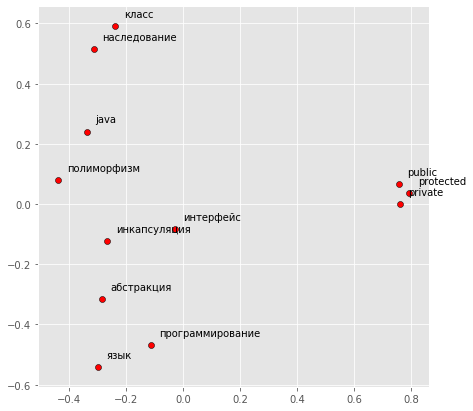

In [9]:


def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words= [word for word in model.vocab]
            
    word_vectors= np.array([model[w] for w in words])
    
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(7,7))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.03, y+0.03, word)
        
        
display_pca_scatterplot(w2v_model.wv,
                        ["класс", "интерфейс", "инкапсуляция", "наследование", 
                         "полиморфизм", "java", "private", "protected", "public",
                         "язык", "абстракция", "программирование"])

In [11]:


def get_name(path):
    name = str(path).split(".")
    name = "_".join(re.findall("[а-яa-zА-ЯA-Z][^А-ЯA-Z]*", name[1])).lower()
    return name


world = World()
onto = world.get_ontology("file://C:\OOPOntology.owl").load()

classes = onto.classes()

for c in classes:
    instances=[]

    instances = [get_name(inst) for inst in onto.get_instances_of(c)]

    #Удаляем индивиды, если их нет в модели.
    for inst in instances:
         if inst not in w2v_model.wv.vocab.keys():
             instances.remove(inst)

    if(instances != []):
        similar = w2v_model.wv.most_similar(positive=instances,
                                        topn=3)

    print(c)
    print(similar)
    #for s in similar:
        #eval("onto." + str(c).split(".")[1] + "(s[0])")

#onto.save(file=r"C:\Users\Nik\PycharmProjects\test\test.owl")


C:\OOPOntology.ЯзыкПрограммирования
[('воплощают', 0.5959833860397339), ('php', 0.5583951473236084), ('c', 0.5258822441101074)]
C:\OOPOntology.ТипДанных
[('воплощают', 0.5959833860397339), ('php', 0.5583951473236084), ('c', 0.5258822441101074)]
C:\OOPOntology.МодификаторДоступа
[('protected', 0.8612021207809448), ('public', 0.8126354217529297), ('обозначающие', 0.77632737159729)]
C:\OOPOntology.ПонятиеООП
[('множественное', 0.5773375034332275), ('единичное', 0.5308322906494141), ('базовым', 0.530362606048584)]
C:\OOPOntology.ПримитивныйТипДанных
[('вещественные', 0.7354960441589355), ('опциональные', 0.6262366771697998), ('обнуляемые', 0.5505951046943665)]
C:\OOPOntology.СсылочныйТипДанных
[('ссылочный', 0.5225247144699097), ('реализовать', 0.47778287529945374), ('входящие', 0.4340800642967224)]
